In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [2]:
#Loading the data from the computer
df=pd.read_csv(r"C:\Users\saipr\Downloads\creditcard.csv\creditcard.csv")
df.dropna(inplace=True)
x=df.drop(columns=['Class','Time'])
y=df['Class']

# Data Preprocessing


scaler=StandardScaler()
x=scaler.fit_transform(x)
print(x[0])

#dividing the data into train,test loaders.


x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)
print(sum(y_train==1),sum(y_train==0))
x_train=torch.tensor(np.array(x_train),dtype=torch.float32)
x_test=torch.tensor(np.array(x_test),dtype=torch.float32)
y_train=torch.tensor(np.array(y_train),dtype=torch.float32)
y_test=torch.tensor(np.array(y_test),dtype=torch.float32)
train_data=TensorDataset(x_train,y_train)
test_data=TensorDataset(x_test,y_test)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=True)


[-0.69424232 -0.04407492  1.6727735   0.97336551 -0.24511658  0.34706795
  0.19367894  0.08263728  0.33112778  0.08338555 -0.54040704 -0.61829572
 -0.99609892 -0.32461019  1.60401384 -0.53683287  0.24486345  0.03076993
  0.49628203  0.32611802 -0.02492336  0.38285444 -0.17691133  0.11050692
  0.24658544 -0.39217043  0.33089162 -0.06378115  0.24496426]
394 227451


In [3]:
class NN(nn.Module):
    def __init__(self,input_size=29):
        super(NN,self).__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,16),
            nn.Tanh(),
            nn.Linear(16,8),
            nn.Tanh(),
            nn.Linear(8,4),
            nn.Tanh(),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.network(x)

In [4]:

model=NN()
criterion=nn.BCELoss(reduction='mean')
optimiser=optim.SGD(model.parameters(),lr=0.01,momentum=0.8)
num_epochs=50

In [9]:
#Model trained in normal data
for epoch in range(num_epochs):
    for input,output in train_loader:
        pred_out=model(input)
        # print(pred_out.size())
        loss=criterion(pred_out.squeeze(),output)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print(f'Loss in epoch [{epoch+1}/{num_epochs}]:{loss}')
    if loss<10e-07:
         break


Loss in epoch [1/50]:7.634867506567389e-05
Loss in epoch [2/50]:0.00023871748999226838
Loss in epoch [3/50]:7.597765943501145e-05
Loss in epoch [4/50]:8.149542554747313e-05
Loss in epoch [5/50]:5.747680552303791e-05
Loss in epoch [6/50]:0.00017643837782088667
Loss in epoch [7/50]:5.955371307209134e-05
Loss in epoch [8/50]:0.0001750514784362167
Loss in epoch [9/50]:6.281519017647952e-05
Loss in epoch [10/50]:7.776210259180516e-05
Loss in epoch [11/50]:0.00015687030099797994
Loss in epoch [12/50]:6.213614688022062e-05
Loss in epoch [13/50]:5.150507058715448e-05
Loss in epoch [14/50]:0.000669857719913125
Loss in epoch [15/50]:0.00013367747305892408
Loss in epoch [16/50]:4.877037645201199e-05
Loss in epoch [17/50]:7.750396616756916e-05
Loss in epoch [18/50]:0.0001251102366950363
Loss in epoch [19/50]:0.00010664111323421821
Loss in epoch [20/50]:0.00019658307428471744
Loss in epoch [21/50]:5.8098084991797805e-05
Loss in epoch [22/50]:0.00027481280267238617
Loss in epoch [23/50]:4.2360970837

classification report of training phase:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    227451
         1.0       0.95      0.83      0.88       394

    accuracy                           1.00    227845
   macro avg       0.97      0.91      0.94    227845
weighted avg       1.00      1.00      1.00    227845



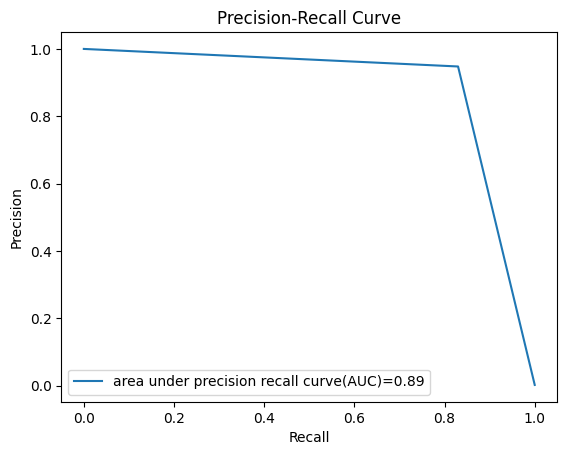

None
classification report of testing phase:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.93      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



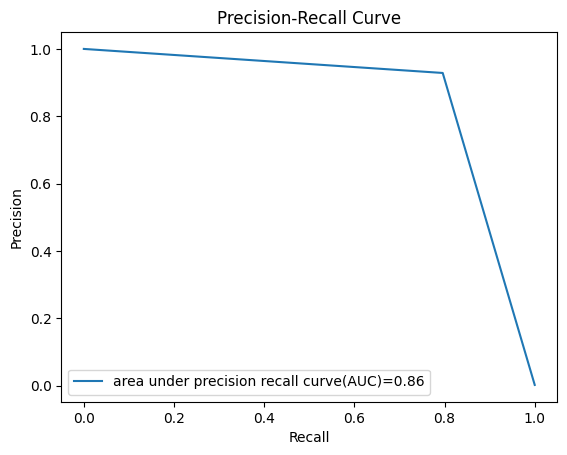

None


In [ ]:
from sklearn.metrics import precision_recall_curve,auc
import matplotlib.pyplot as plt
def accuracy(model,dataloader,classes):
    model.eval()
    with torch.no_grad():
        y_test,y_pred=[],[]
        for input,output in dataloader:
            pred_out=model(input)
            y_test.extend(output.numpy())
            pred_out=(pred_out>0.5).float()
            y_pred.extend(pred_out.numpy())
        #classes=dataloader.classes
        """cor,tot=[],[]
        for i in range(len(classes)):
            cor.append(sum(1 for j,k in zip(y_test,y_pred) if j==i and k==i))
            tot.append(sum (1 for j in y_test if j==i))
            print("precision of each class:")
        for i,cl in enumerate(classes):
            print(f'{cl}:[{cor[i]}/{tot[i]}]')"""
        print(classification_report(y_test,y_pred))
        prec,rec,thr=precision_recall_curve(y_test,y_pred)
        plt.figure()
        plt.plot(rec,prec,label=f'area under precision recall curve(AUC)={auc(rec,prec):0.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
    model.train()
print("classification report of training phase:")
print(accuracy(model,train_loader,['NonFraud','Fraud']))
print("classification report of testing phase:")
print(accuracy(model,test_loader,['NonFraud','Fraud']))

In [7]:
#svm classify
#training is not much better.

After smoting the data
training(smoted data) accuracy:


NameError: name 'train_loader_smote' is not defined